# scCODA - Compositional analysis of single-cell data

The scCODA package ([Büttner, Ostner et al., 2020](https://www.biorxiv.org/content/10.1101/2020.12.14.422688v2)) is intended to be used with cell composition from single-cell RNA-seq experiments, however there are no technical restrictions that prevent the use of data from other sources.

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")
import session_info

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import arviz as az

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

## Data preparation

In [2]:
# Loading data --> cell counts by CELL TYPE
cell_counts = pd.read_excel("results/tables/FIXnCUT_MouseLung_cryopreserved_clustering_annotation_cleaned_counts.xlsx")
comparison_name = "FC-C"

cell_counts.head()

,library_name,Alveolar Macrophages,Arterial cells,B cells,Bipotent Capillary cells,Capillary aerocyte (aCap) cells,Capillary general (gCap) cells,Club cells,Cycling cells,Fibroblasts,...,Macrophages Apoe+,Monocyte-derived DCs,Monocytes,NK cells,Pericytes,Pneumocytes Type I,Pneumocytes Type II,T cells,Vein cells,sample_protocol
0,Cryopreserved,578,428,534,910,477,1017,26,53,321,...,242,132,1099,177,168,138,144,400,125,Cryopreserved
1,Fixed,401,903,753,1424,388,1358,13,34,505,...,262,133,788,166,245,441,115,456,217,Fixed
2,Fixed+Cryopreserved,240,265,72,813,301,1230,14,21,231,...,216,93,735,61,108,97,129,108,114,Fixed+Cryopreserved


In [3]:
cell_counts = cell_counts[(cell_counts["library_name"] == "Cryopreserved") |
                          (cell_counts["library_name"] == "Fixed+Cryopreserved")]

To use the models in scCODA, we first have to convert the data into an anndata object. This can be done easily with the sccoda.util.cell_composition_data module. The resulting object separates our data components: 
* Cell counts are stored in data.X as a numpy array with the dimensions.
* Covariates are stored in data.obs as a pandas DataFrame.
* Additional information on the cell types can be stored in adata.var.

In [5]:
# Convert data to anndata object
data_all = dat.from_pandas(
    cell_counts, 
    covariate_columns=["library_name", "sample_protocol" ])

print(data_all)

AnnData object with n_obs × n_vars = 2 × 19
    obs: 'library_name', 'sample_protocol'


In [5]:
#print(data_all.X)
#print(data_all.obs)

For our first example, we want to look at TISSUE influences the cell composition in the patients with oJIA disease. Therefore, we subset our data.

## Compositional data visualization

Analyzing compositional data is not straightforward. scCODA provides some ways of visualizing the properties of a compositional dataset before analysis. 

### Stacked barplots

The most common representation of cell count data in genomic research are stacked barplots.

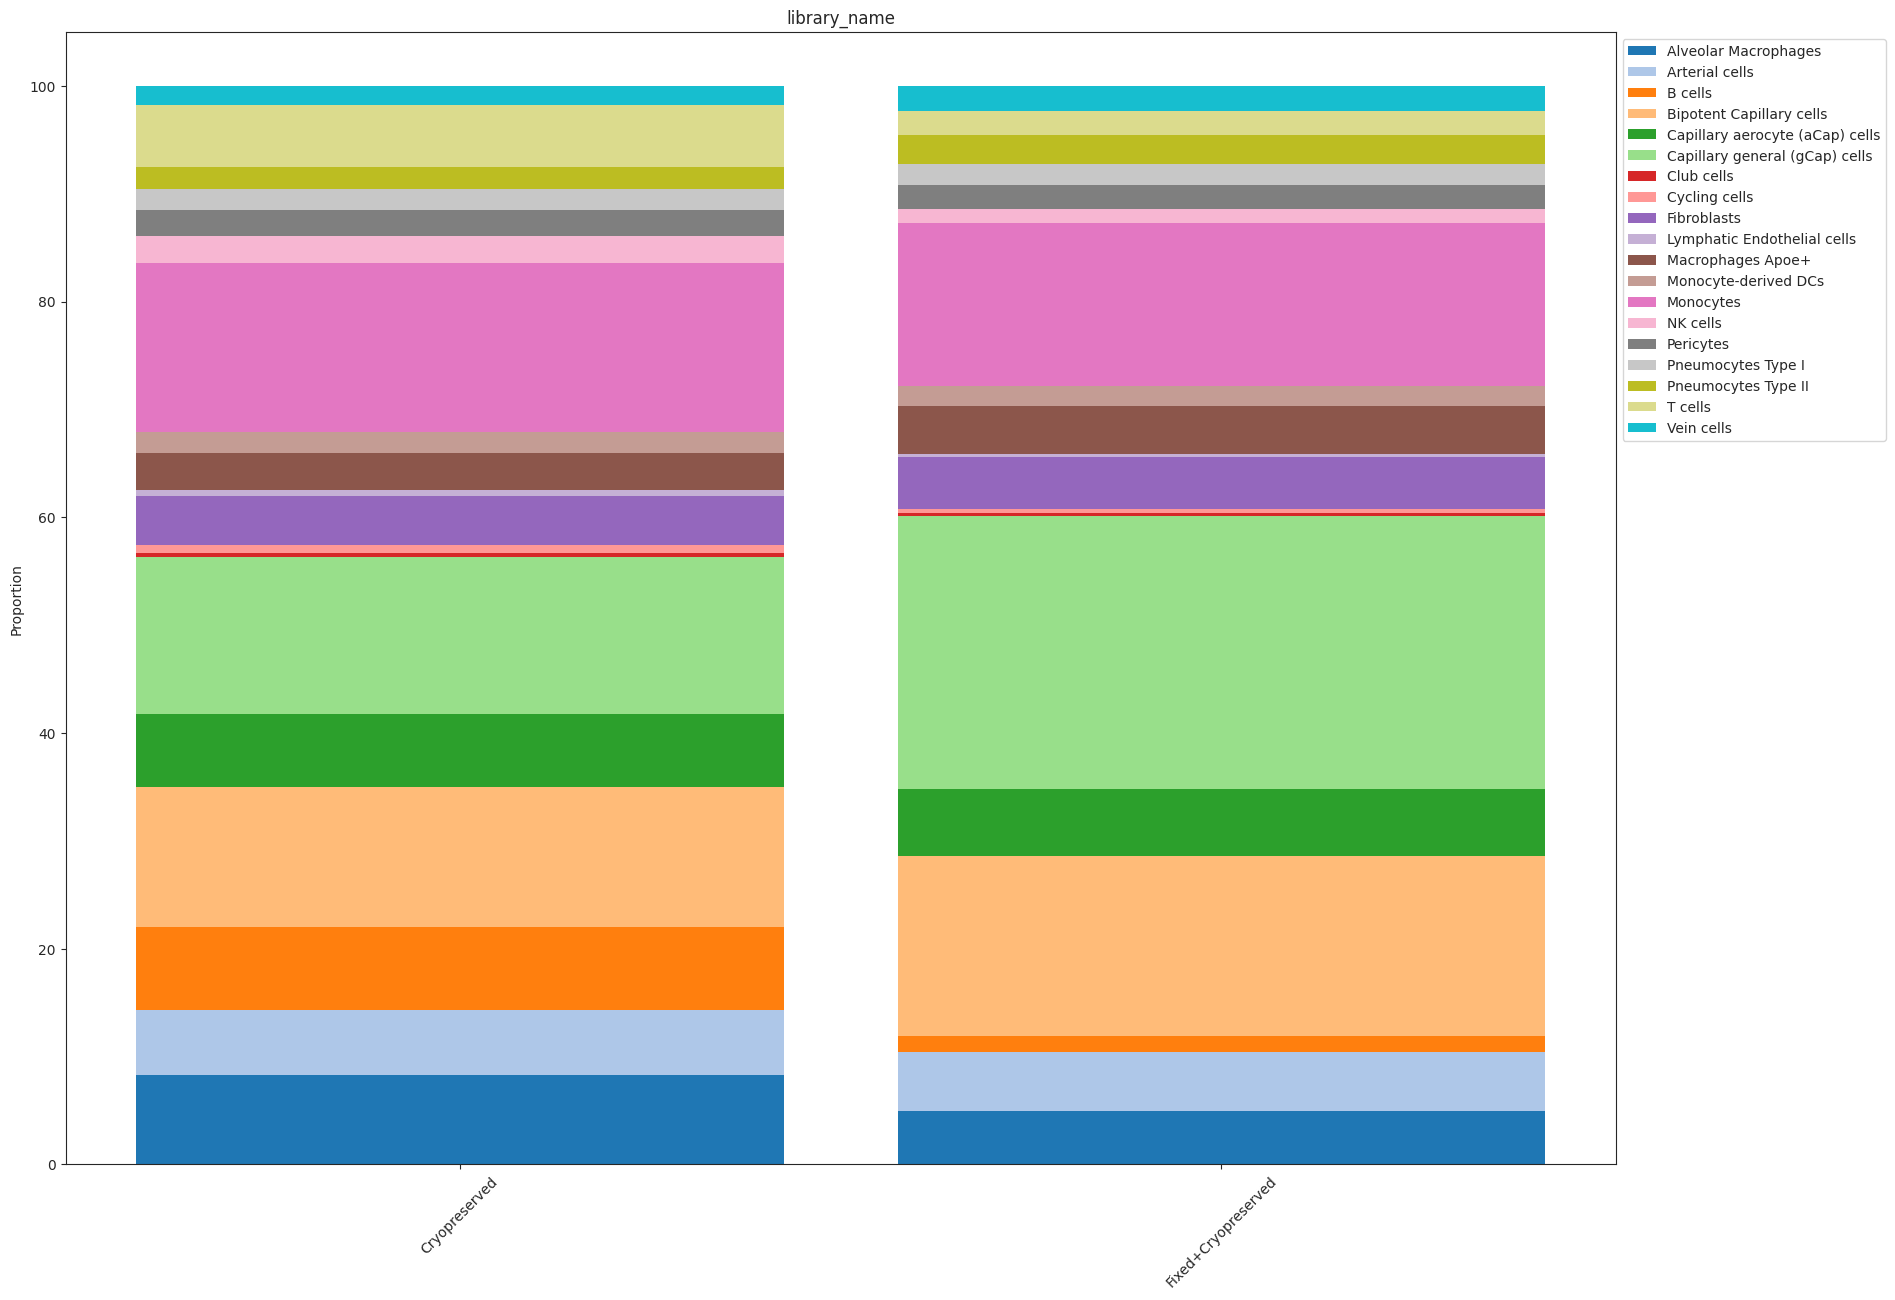

In [6]:
# Stacked barplot for each sample
viz.stacked_barplot(
    data_all, 
    feature_name="library_name"
)
figure = plt.gcf()
figure.set_size_inches(20, 15)
figure.savefig(f"results/figs/MouseLung_cryo_scCODA_{comparison_name}_stackedbarplot-sample.png",
              bbox_inches='tight')

**DATA INTERPRETATION**

Plotting the data, we can see that there is ..

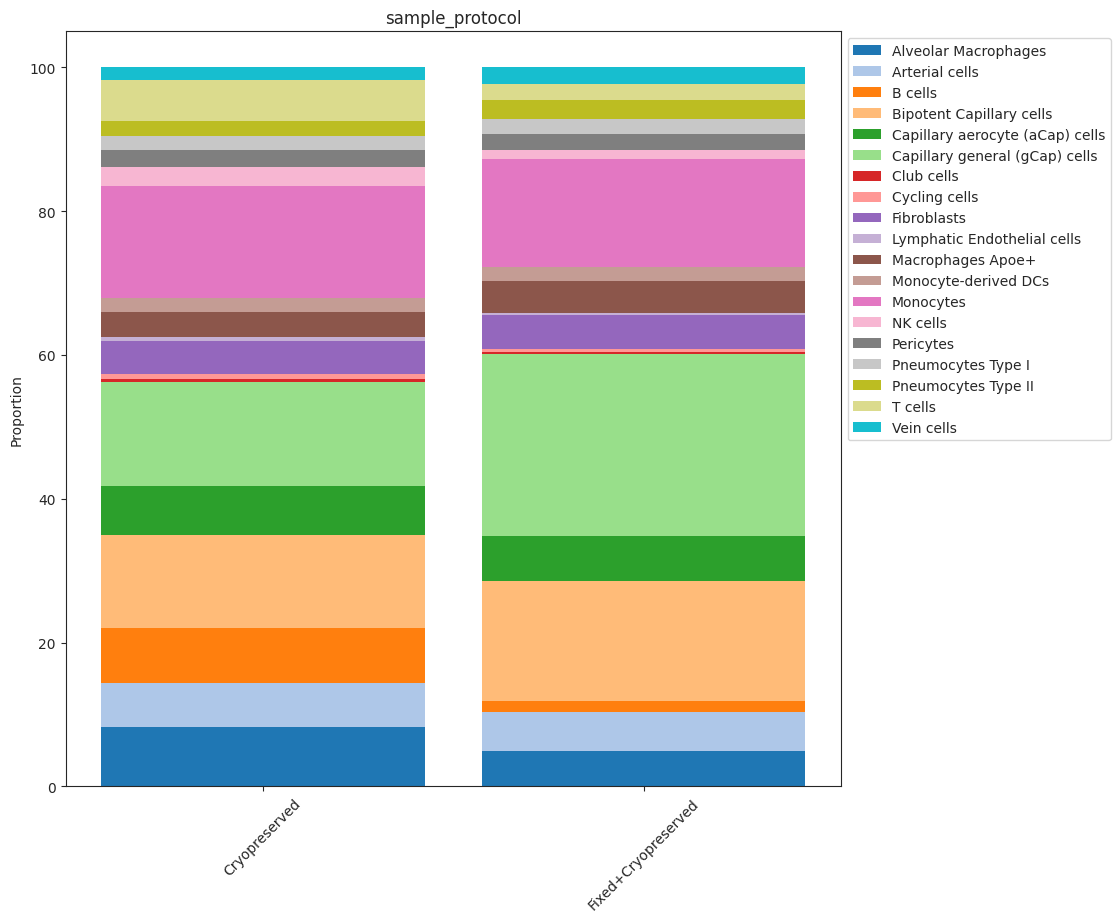

In [7]:
# Stacked barplot for the levels of "Tissue"
viz.stacked_barplot(
    data_all, 
    feature_name="sample_protocol"
)
figure = plt.gcf()
figure.set_size_inches(10, 10)
figure.savefig(f"results/figs/MouseLung_cryo_scCODA_{comparison_name}_stackedbarplot-condition.png",
              bbox_inches='tight')

### Grouped boxplots

While stached barplots are a nice and compact way of representing compositional data, they omit crucial information about the data variance. Also, comparing the abundance of cell types that are not on the top or bottom of the bars can be hard.

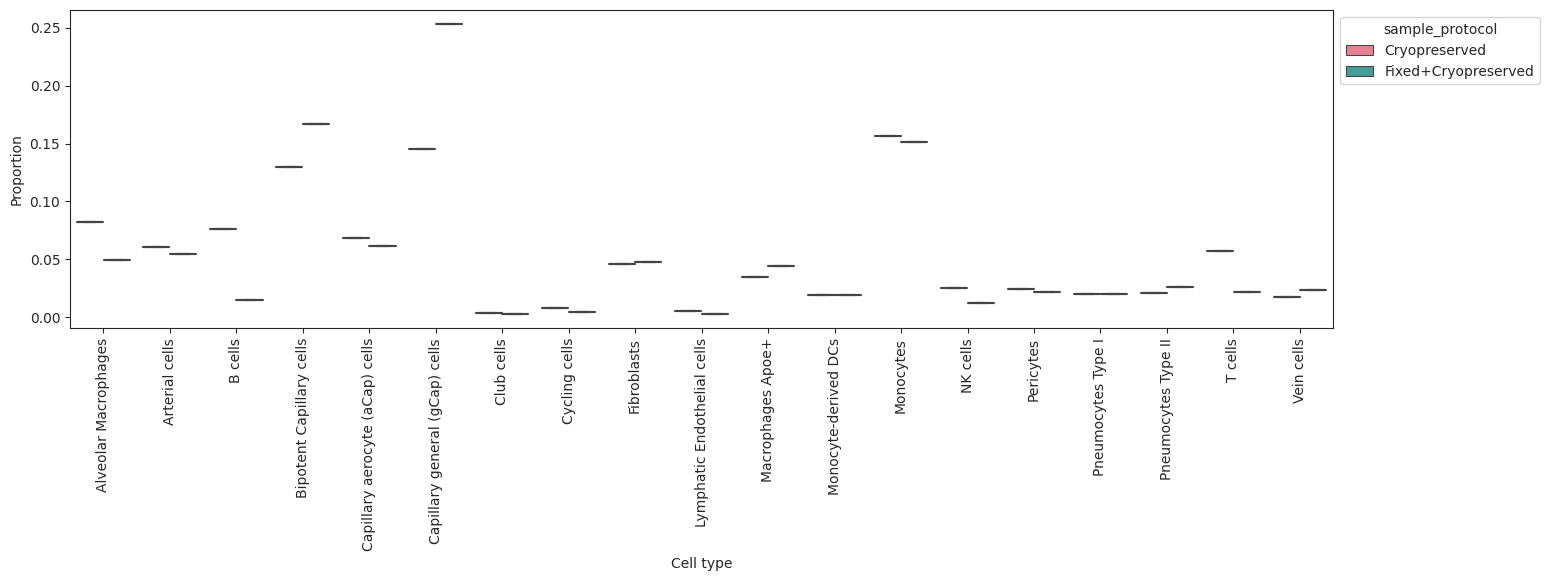

In [8]:
# Grouped boxplots. No facets, relative abundance, no dots.
viz.boxplots(
    data_all, 
    feature_name="sample_protocol", 
    cmap = "husl",
    plot_facets=False,
    y_scale="relative", # relative, log
    add_dots=False
)
figure = plt.gcf()
figure.set_size_inches(25, 10)
figure.savefig(f"results/figs/MouseLung_cryo_scCODA_{comparison_name}_boxplot.png",
              bbox_inches='tight')

**DATA INTERPRETATION**

Plotting the data, we can see that ....

Since scRNA-seq experiments are limited in the number of cells per sample, the count data is compositional, which leads to negative correlations between the cell types. Thus, the slight decreases in many cell types might be fully caused by the increase in some specific cell types or viceversa.

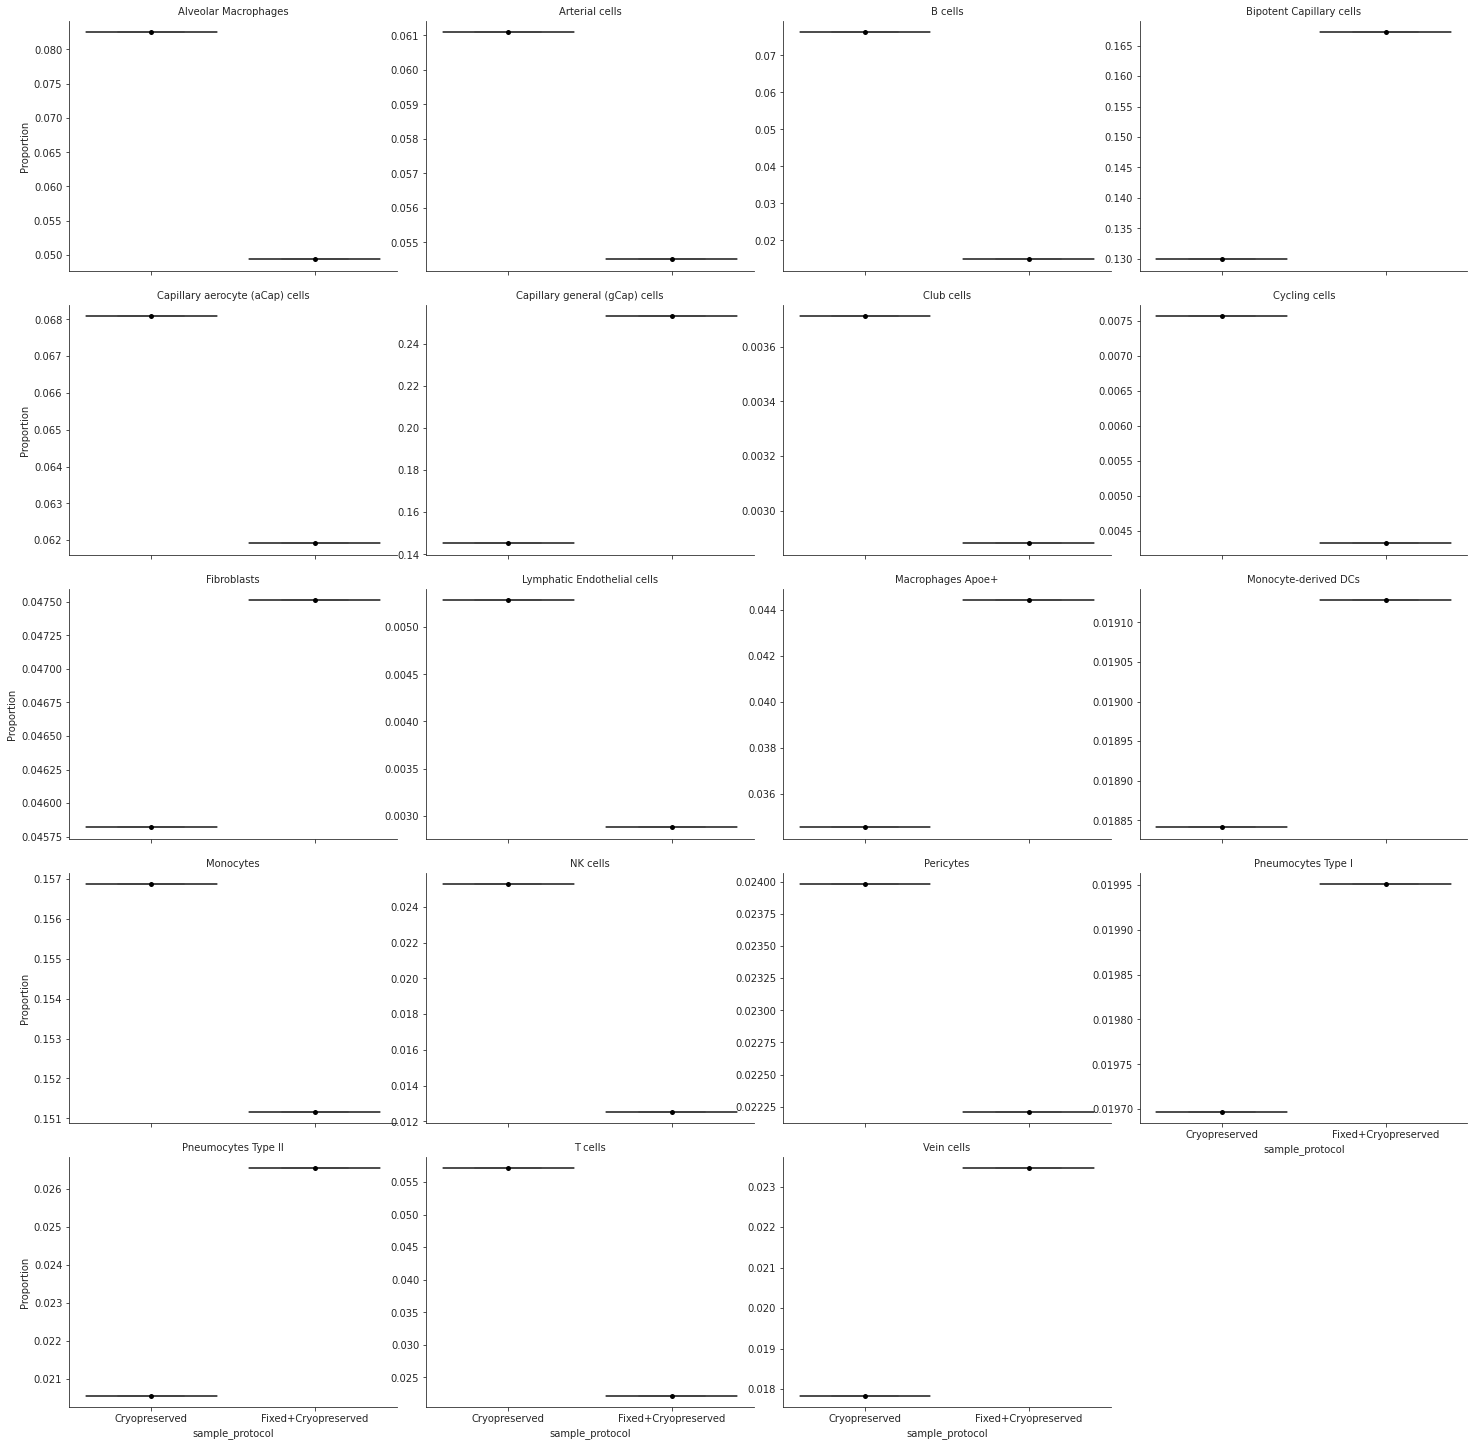

In [9]:
# Grouped boxplots. Facets, log scale, added dots and custom color palette.
viz.boxplots(
    data_all, 
    feature_name="sample_protocol", 
    cmap = "husl",
    plot_facets=True,
    y_scale="relative", # relative, log
    add_dots=True
)
figure = plt.gcf()
figure.set_size_inches(20, 20)
figure.savefig(f"results/figs/MouseLung_cryo_scCODA_{comparison_name}_boxplot-celltype.png",
              bbox_inches='tight')

## Finding a reference cell type

The scCODA model requires a cell type to be set as the reference category. However, choosing this cell type is often difficult. A good first choice is a referenece cell type that closely preserves the changes in relative abundance during the compositional analysis.

For this, it is important that the reference cell type is not rare, to avoid large relative changes being caused by small absolute changes. Also, the relative abundance of the reference should vary as little as possible across all samples.

For this, it is important that the reference cell type is not rare, to avoid large relative changes being caused by small absolute changes. Also, the relative abundance of the reference should vary as little as possible across all samples.

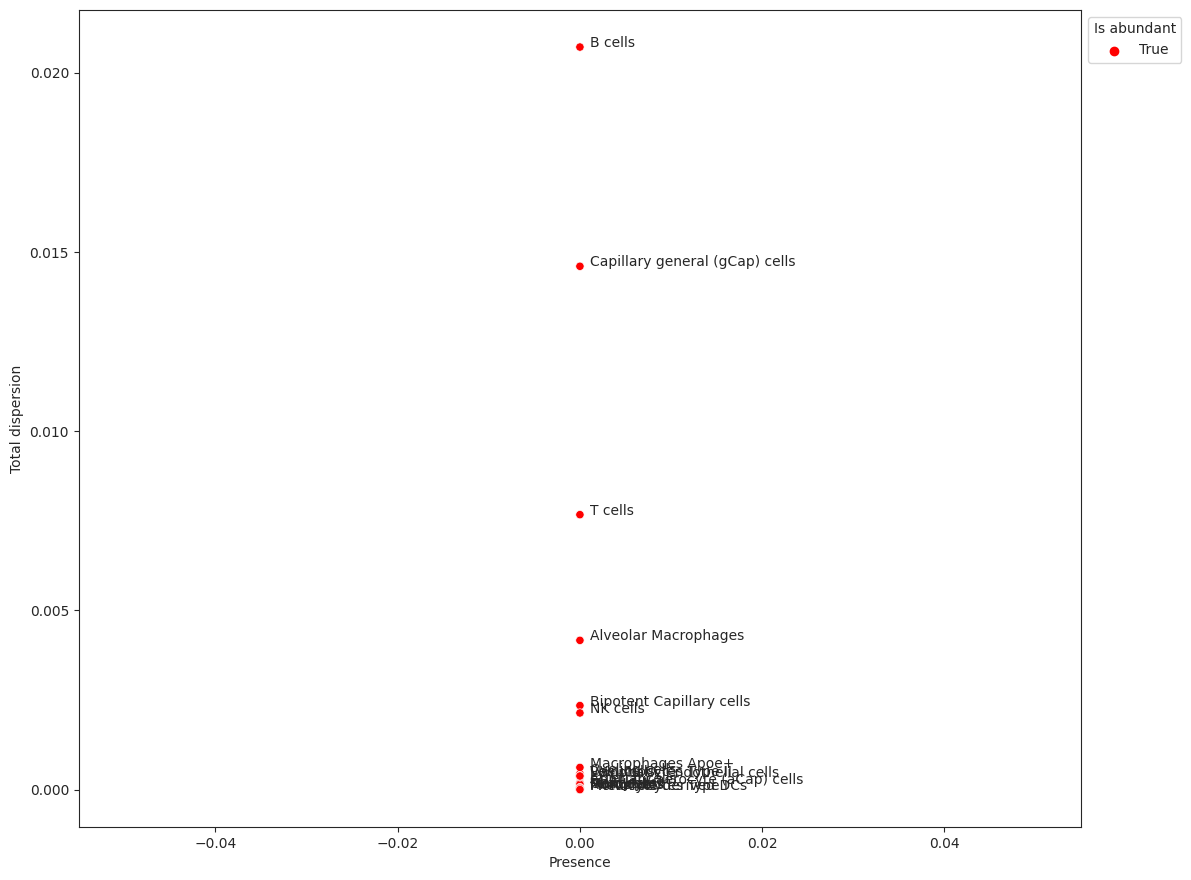

In [10]:
# Reference cell type
viz.rel_abundance_dispersion_plot(
    data=data_all,
    abundant_threshold=0.9
)
figure = plt.gcf()
figure.set_size_inches(15, 10)
#figure.savefig(f"results/figs/MouseLung_cryo_scCODA_{comparison_name}_refcelltype.png",
#              bbox_inches='tight')

## Model setup and inference

We can now create the model and run inference on it. Creating a sccoda.util.comp_ana.CompositionalAnalysis class object sets up the compositional model and prepares everxthing for parameter inference. It needs these informations:
* The **data object** from above.
* The **formula parameter**. It specifies how the covariates are used in the model. It can process R-style formulas via the patsy package, e.g. formula="Cov1 + Cov2 + Cov3". Here, we simply use the “Condition” covariate of our dataset.
* The **reference_cell_type parameter** is used to specify a cell type that is believed to be unchanged by the covariates in formula. This is necessary, because compositional analysis must always be performed relative to a reference (See Büttner, Ostner et al., 2020 for a more thorough explanation). If no knowledge about such a cell type exists prior to the analysis, taking a cell type that has a nearly constant relative abundance over all samples is often a good choice. It is also possible to let scCODA find a suited reference cell type by using reference_cell_type="automatic".

**TWEAKING THE FORMULA PARAMETER**

First, we take a closer look at how changing the formula parameter of the scCODA model influences the results. Internally, the formula string is converted into a linear model-like design matrix via patsy, which has a similar syntax to the lm function in the R language.

    1. Multi-level categories
    
Patsy allows us to automatically handle categorical covariates, even with multiple levels.

    2. Different reference category levels
    
Per default, categorical variables are encoded via full-rank treatment coding. Hereby, the value of the first sample in the dataset is used as the reference (control) category. We can select the control level by changing the model formula to:

    `"C(<CovariateName>, Treatment('<ReferenceLevelName>'))"`.
    
 

**SWITCHING THE REFERENCE CELL TYPE PARAMETER**

Compositional analysis generally does not allow statements on absolute abundance changes, but only in relation to a reference category, which is assumed to be unchanged in absolute abundance. The reference cell type fixes this category in scCODA. Thus, an interpretation of scCODA’s effects should always be formulated like:

“Using cell type xy as a reference, cell types (a, b, c) were found to credibly change in abundance”

Switching the reference cell type might thus produce different results. For example, if we choose a cell type that heavily increases in relative abundance as the reference, scCODA will likely find many credible negative effects on the other cell types.


**Inference algorithms in scCODA**

Currently, scCODA performs parameter inference via Markov-chain Monte Carlo (MCMC) methods. There are three different MCMC sampling methods available for scCODA:
* Hamiltonian Monte Carlo (HMC) sampling: `sample_hmc()`
* HMC sampling with Dual-averaging step size adaptation (Nesterov, 2009): `sample_hmc_da()`
* No-U-Turn sampling (Hoffman and Gelman, 2014): `sample_nuts()`

Generally, it is recommended to use the standard HMC sampling.

In [13]:
formula_parameter = "C(sample_protocol, Treatment('Cryopreserved'))"
reference_cell_type_parameter = "Lymphatic Endothelial cells" # or automatic (to match with C vs F & FC vs F) 

model = mod.CompositionalAnalysis(
    data_all, 
    formula = formula_parameter, 
    reference_cell_type = reference_cell_type_parameter
)

In [14]:
# Run MCMC
results = model.sample_hmc()

MCMC sampling finished. (49.441 sec)
Acceptance rate: 76.0%


### Results interpretation

**Model properties**

First, the summary shows an overview over the model properties: 
* Number of samples/cell types 
* The reference cell type. 
* The formula used

The model has two types of parameters that are relevant for analysis - intercepts and effects. These can be interpreted like in a standard regression model: 
* Intercepts show how the cell types are distributed without any active covariates.
* Effects show how the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The “Expected sample” column gives some context to the numerical values. If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset, then this distribution over the cell types would be most likely.

**Effects**

For the effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types. Most important is the distinctions between zero and non-zero entries:
* A value of zero means that no statistically credible effect was detected. 
* For a value other than zero, a credible change was detected. 
    * A positive sign indicates an increase
    * A negative sign a decrease in abundance.

Since the numerical values of the “Final parameter” columns are not straightforward to interpret, the “Expected sample” and “log2-fold change” columns give us an idea on the magnitude of the change. The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts. The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section. Since the data is compositional, cell types for which no credible change was detected, are expected to change in abundance as well.

In [14]:
# Result interpretation
#results.summary()

In [15]:
# Results interpretation in a dataframe
results.effect_df

Final Parameter  \
Covariate                                          Cell Type                                          
C(sample_protocol, Treatment('Cryopreserved'))[... Alveolar Macrophages                    0.000000   
                                                   Arterial cells                          0.000000   
                                                   B cells                                -1.202030   
                                                   Bipotent Capillary cells                0.000000   
                                                   Capillary aerocyte (aCap) cells         0.000000   
                                                   Capillary general (gCap) cells          0.615809   
                                                   Club cells                              0.000000   
                                                   Cycling cells                           0.000000   
                                                   Fibroblasts                             0.000000   
                                                   Lymphatic Endothelial cells             0.000000   
                                                   Macrophages Apoe+                       0.000000   
                                                   Monocyte-derived DCs                    0.000000   
                                                   Monocytes                               0.000000   
                                                   NK cells                                0.000000   
                                                   Pericytes                               0.000000   
                                                   Pneumocytes Type I                      0.000000   
                                                   Pneumocytes Type II                     0.000000   
                                                   T cells                                -0.700670   
                                                   Vein cells                              0.000000   

                                                                                    HDI 3%  \
Covariate                                          Cell Type                                 
C(sample_protocol, Treatment('Cryopreserved'))[... Alveolar Macrophages             -1.027   
                                                   Arterial cells                   -0.516   
                                                   B cells                          -1.896   
                                                   Bipotent Capillary cells         -0.055   
                                                   Capillary aerocyte (aCap) cells  -0.442   
                                                   Capillary general (gCap) cells   -0.019   
                                                   Club cells                       -0.868   
                                                   Cycling cells                    -1.096   
                                                   Fibroblasts                      -0.500   
                                                   Lymphatic Endothelial cells       0.000   
                                                   Macrophages Apoe+                -0.256   
                                                   Monocyte-derived DCs             -0.630   
                                                   Monocytes                        -0.429   
                                                   NK cells                         -1.325   
                                                   Pericytes                        -0.714   
                                                   Pneumocytes Type I               -0.701   
                                                   Pneumocytes Type II              -0.408   
                                                   T cells                          -1.473   
                                        

In [16]:
# Filter out all credible effects
results.credible_effects()

Covariate                                                              Cell Type                      
C(sample_protocol, Treatment('Cryopreserved'))[T.Fixed+Cryopreserved]  Alveolar Macrophages               False
                                                                       Arterial cells                     False
                                                                       B cells                             True
                                                                       Bipotent Capillary cells           False
                                                                       Capillary aerocyte (aCap) cells    False
                                                                       Capillary general (gCap) cells      True
                                                                       Club cells                         False
                                                                       Cycling cells                      False
 

**DATA INTERPRETATION**

In the previous analysis, we see multiple credible changes on cell type composition between tissues. For instance, there is ...

### Saving results

In [17]:
# Save all information as pickle object
results.save(
    f"results/MouseLung_cryo_scCODA_{comparison_name}.pickle", 
)

# Loading information from pickle file
#pickle_file_path = f"results/MouseLung_cryo_scCODA_{comparison_name}.pickle"
#with open(pickle_file_path, "rb") as f:
#    results = pkl.load(f)

# Save all information as tsv file
results.to_dataframe().to_csv(
    f"results/tables/MouseLung_cryo_scCODA_{comparison_name}_allinfo.tsv", 
    sep='\t')

# Save effect information as tsv file
results.effect_df.to_csv(
    f"results/tables/MouseLung_cryo_scCODA_{comparison_name}_effect.tsv", 
    sep='\t')

In [39]:
session_info.show()